<h1> Week 5. Convolutional neural networks (CNN) </h1>

<h3>Import Pytorch libraries </h3>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

<h3> Load the CIFAR-10 dataset </h3>

In [4]:
#from ipywidgets import IProgress
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
batch_size = 256
 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print(trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
print(trainloader)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)
 
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


<h3>Plot one batch of 32x32 images of the CIFAR-10 dataset</h3>

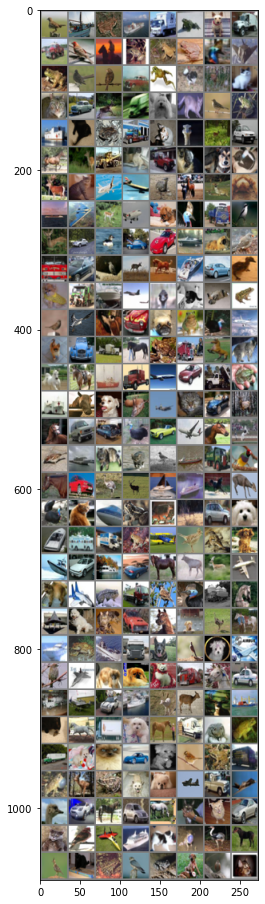

 bird  ship  frog  ship truck  frog   dog truck truck  bird horse  frog  frog  frog  bird plane  frog  bird  bird   car  frog   dog  deer   cat   cat   car  deer truck   dog   cat  bird  frog  ship   cat  frog truck   cat  bird  deer   car horse  deer truck   cat   car   dog   dog   cat  deer   cat plane plane  bird horse  deer   cat  ship plane  deer plane   dog  bird truck  bird  deer   car  bird   car   car   car   dog  bird truck   car  bird  deer horse  ship   car  bird   dog truck  ship plane  bird   cat   cat  frog  bird  bird   cat   car   dog  frog  bird plane   dog   car truck horse  frog truck horse   cat horse horse  ship truck plane   car truck  frog  ship horse   dog  deer plane   cat   car  deer horse   car   car  bird   car plane horse horse  bird  ship   cat   cat  bird  ship truck  bird horse   car  bird  deer  ship  ship horse  deer  bird   cat plane  frog  deer  deer   car   dog  ship truck truck  frog plane  bird  bird   dog  ship   car  ship   car horse  deer  dee

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
f = plt.figure (figsize = (16,16))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

<h1> Simple CNN architecture </h1>

<h3> Building a simple CNN architecture for the classifying images from the CIFAR-10</h3>

In [50]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x.to (device)
        return x


net = Net()

In [ ]:
!pip install torchviz
!pip install graphviz

<h3> Show a computation graph 

In [48]:
batch = next(iter(trainloader))
yhat = net (batch[0])
from torchviz import make_dot
make_dot(yhat, params=dict(list(net.named_parameters())))

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

<h3> Run on a CPU </h3>

In [7]:
import torch.optim as optim
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print (device)
net = net.to (device)

cpu


<h3> Run on  a single GPU </h3>

In [51]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print (device)

cuda:0


<h3> Run parallel on Multiple GPUs </h3>

In [ ]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net, device_ids = [0,1])
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
print (device)

<h3> CNN training on a CIFAR-10 </h3>

In [52]:
import time

start = time.time()

for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to (device)
        labels = labels.to (device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
end = time.time()
print(end - start)

Finished Training
291.56973576545715


<h3> Visualize predictions </h3>

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(12)))

<h3> Calculate accuracy and other metrics </h3>

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

<h3> Calculate accuracy for each class separately </h3>

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

<h1>Alex-Net CNN architecture </h1>

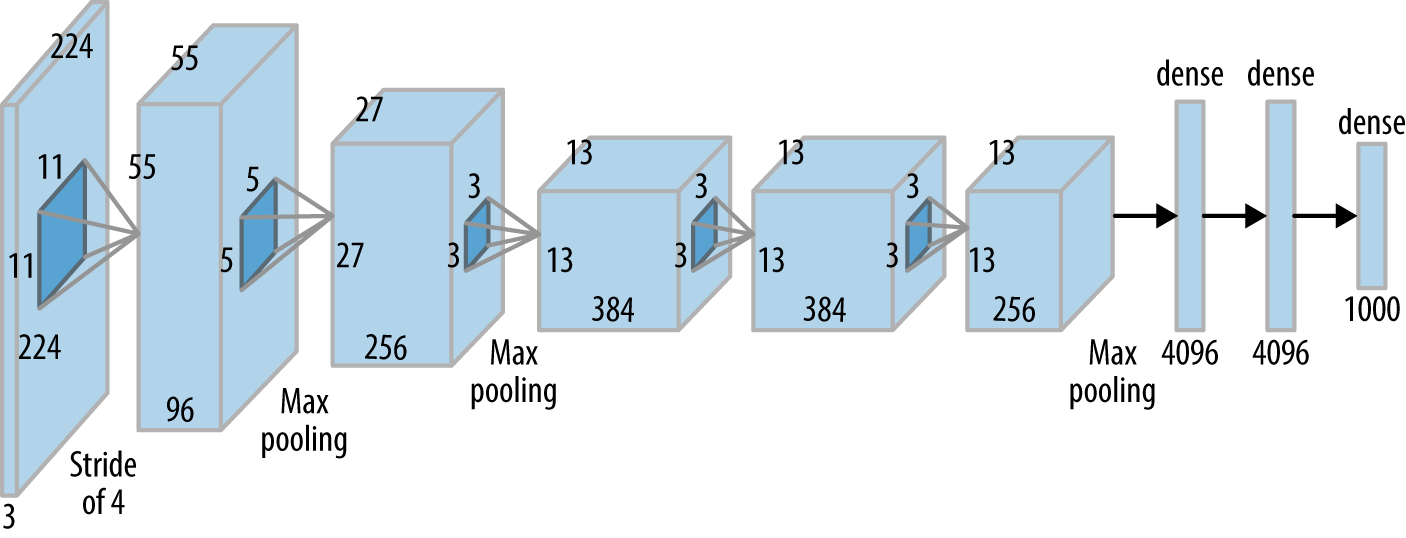

In [6]:
NUM_CLASSES = 10
import torch.nn as nn
import torch.nn.functional as F
class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        x = x.to (device)
        return x

<h3> Alex-Net initialize the network loss and optimizer </h3>

In [53]:
import torch.optim as optim
net = AlexNet ()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD (net.parameters(), lr=0.001, momentum=0.9)

<h3> Use available GPUs to perform training by using DataParallel package </h3>

In [9]:
import torch.optim as optim
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net, device_ids = [0,1])
net.to(device)
print (device)

cuda:0


<h3> Run the training procedure for the CIFAR-10 dataset </h3>

In [21]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to (device)
        labels = labels.to (device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.023
[1,    51] loss: 1.137
[1,   101] loss: 1.147
[1,   151] loss: 1.158
[2,     1] loss: 0.022
[2,    51] loss: 1.129
[2,   101] loss: 1.153
[2,   151] loss: 1.142
[3,     1] loss: 0.023
[3,    51] loss: 1.140
[3,   101] loss: 1.130
[3,   151] loss: 1.124
[4,     1] loss: 0.021
[4,    51] loss: 1.103
[4,   101] loss: 1.106
[4,   151] loss: 1.117
[5,     1] loss: 0.025
[5,    51] loss: 1.099
[5,   101] loss: 1.076
[5,   151] loss: 1.083
[6,     1] loss: 0.020
[6,    51] loss: 1.070
[6,   101] loss: 1.078
[6,   151] loss: 1.076
[7,     1] loss: 0.021
[7,    51] loss: 1.067
[7,   101] loss: 1.063
[7,   151] loss: 1.085
[8,     1] loss: 0.021
[8,    51] loss: 1.054
[8,   101] loss: 1.056
[8,   151] loss: 1.038
[9,     1] loss: 0.020
[9,    51] loss: 1.051
[9,   101] loss: 1.024
[9,   151] loss: 1.042
[10,     1] loss: 0.020
[10,    51] loss: 1.023
[10,   101] loss: 1.018
[10,   151] loss: 1.007
[11,     1] loss: 0.021
[11,    51] loss: 1.008
[11,   101] loss: 0.996
[11,

[86,   151] loss: 0.156
[87,     1] loss: 0.003
[87,    51] loss: 0.188
[87,   101] loss: 0.150
[87,   151] loss: 0.139
[88,     1] loss: 0.003
[88,    51] loss: 0.127
[88,   101] loss: 0.129
[88,   151] loss: 0.124
[89,     1] loss: 0.003
[89,    51] loss: 0.151
[89,   101] loss: 0.120
[89,   151] loss: 0.145
[90,     1] loss: 0.001
[90,    51] loss: 0.113
[90,   101] loss: 0.117
[90,   151] loss: 0.138
[91,     1] loss: 0.002
[91,    51] loss: 0.115
[91,   101] loss: 0.099
[91,   151] loss: 0.109
[92,     1] loss: 0.002
[92,    51] loss: 0.101
[92,   101] loss: 0.115
[92,   151] loss: 0.156
[93,     1] loss: 0.003
[93,    51] loss: 0.107
[93,   101] loss: 0.083
[93,   151] loss: 0.101
[94,     1] loss: 0.002
[94,    51] loss: 0.091
[94,   101] loss: 0.153
[94,   151] loss: 0.133
[95,     1] loss: 0.002
[95,    51] loss: 0.088
[95,   101] loss: 0.073
[95,   151] loss: 0.087
[96,     1] loss: 0.001
[96,    51] loss: 0.100
[96,   101] loss: 0.176
[96,   151] loss: 0.151
[97,     1] loss

[169,    51] loss: 0.008
[169,   101] loss: 0.005
[169,   151] loss: 0.005
[170,     1] loss: 0.000
[170,    51] loss: 0.007
[170,   101] loss: 0.005
[170,   151] loss: 0.005
[171,     1] loss: 0.000
[171,    51] loss: 0.004
[171,   101] loss: 0.003
[171,   151] loss: 0.002
[172,     1] loss: 0.000
[172,    51] loss: 0.002
[172,   101] loss: 0.002
[172,   151] loss: 0.001
[173,     1] loss: 0.000
[173,    51] loss: 0.002
[173,   101] loss: 0.002
[173,   151] loss: 0.002
[174,     1] loss: 0.000
[174,    51] loss: 0.001
[174,   101] loss: 0.002
[174,   151] loss: 0.001
[175,     1] loss: 0.000
[175,    51] loss: 0.001
[175,   101] loss: 0.001
[175,   151] loss: 0.001
[176,     1] loss: 0.000
[176,    51] loss: 0.001
[176,   101] loss: 0.001
[176,   151] loss: 0.001
[177,     1] loss: 0.000
[177,    51] loss: 0.002
[177,   101] loss: 0.001
[177,   151] loss: 0.001
[178,     1] loss: 0.000
[178,    51] loss: 0.001
[178,   101] loss: 0.001
[178,   151] loss: 0.001
[179,     1] loss: 0.000


In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to (device)
        labels = labels.to (device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        if (total < 10):
            print (outputs, ' ', predicted, ' ', labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print (correct)
print (total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

tensor([[ -7.9246,  -6.5249,   0.0455,  ...,  -7.5869,   4.3160,   3.6341],
        [ 11.5742,  27.4562, -16.2848,  ..., -35.0696,  38.4542,  17.3139],
        [  9.4879,  16.5407,  -9.7470,  ..., -15.9510,  19.3890,  14.9848],
        ...,
        [  2.2765,  -0.5511,  -3.8905,  ...,   2.2607,   3.6798,  20.4575],
        [ -1.9673,  -9.5222,  10.0931,  ...,  -3.8745, -10.7791,  -9.0181],
        [ 10.0919,   2.5191,   0.3265,  ...,  -3.8351,   6.3005,   3.7494]],
       device='cuda:0')   tensor([3, 8, 8, 0, 6, 6, 1, 4, 5, 1, 4, 9, 4, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 2, 4, 0, 9, 6, 6, 5, 2, 3, 9, 1, 4, 9, 9, 5, 4, 6, 5, 6, 0, 9, 3, 3,
        7, 6, 9, 8, 2, 3, 8, 8, 7, 3, 3, 2, 7, 5, 6, 3, 6, 2, 1, 2, 5, 7, 2, 6,
        8, 8, 0, 2, 0, 3, 3, 8, 8, 1, 1, 4, 5, 7, 7, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 9, 1, 2, 6, 8, 7, 4, 0, 2, 2, 9, 7, 0, 4, 5, 5,
        8, 0, 1, 2, 8, 8, 8, 3, 3, 0, 4, 1, 9, 9, 1, 2, 9, 7, 2, 8, 6, 5, 6, 3,
        8, 5, 3, 5, 5, 2

In [23]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to (device)
        labels = labels.to (device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 72.7 %
Accuracy for class car   is: 76.5 %
Accuracy for class bird  is: 61.9 %
Accuracy for class cat   is: 50.3 %
Accuracy for class deer  is: 62.4 %
Accuracy for class dog   is: 60.8 %
Accuracy for class frog  is: 77.5 %
Accuracy for class horse is: 72.2 %
Accuracy for class ship  is: 78.4 %
Accuracy for class truck is: 80.5 %


In [45]:
import torchvision.models as models
resnet18 = models.resnet18()
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()

C:\Users\NU\Anaconda3\envs\pytor_c\lib\site-packages\torchvision\models\googlenet.py:79: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


<h1> Tasks for the lab </h1>

<h3> 1. Train the Alex-Net neural network with the use of Adam optimizer. Number of epochs should be 200, batch size - 256. Provide code for calculating accuracy values and the training loop for the given network in the box below. </h3>

In [ ]:
#put code for calculating accuracy here

<h3> 2. Train the Alex-Net will the following changes:
    </h3>
    <ul>
        <li>Add Normalization of mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]</li>
        <li>Choose a random subset of 8 classes for the training/testing. </li>
        <li>Calculate the accurary and a confusion matrix for the given 8 classes</li>
    </ul>

<h3> 3. From the torchvision module import models and compare performances of VGG-16, resnet-18 and Alex-Net on a CIFAR-10 dataset </h3>